In [49]:
import numpy as np
import scipy.optimize as sc
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks

plt.rcParams['figure.dpi'] = 150

In [50]:
Data_names = []

# Method for going through all the data we have, and it fucking works dawg
for (dir_path, dir_names, file_names) in os.walk('./Data_Labday_1'):
    for file_name in file_names:
        if file_name.endswith('.txt'): #ensures we grab only the files ending with .txt
            Data_names.append(os.path.join(dir_path, file_name))

In [51]:
wavelength = [] #Wavelength list
Intensity = [] # Intensity list


for Data_name in Data_names:
    Data = np.loadtxt(Data_name, skiprows=1)
    wavelength.append(Data[:, 0])
    Intensity.append(Data[:, 1]) 

[587.249, 596.482, 604.853, 611.535, 616.12, 623.61, 628.594, 632.326, 635.226, 641.845, 652.571, 661.618, 669.82, 673.504, 694.701, 704.84, 719.378, 726.219, 745.847, 839.657]
9


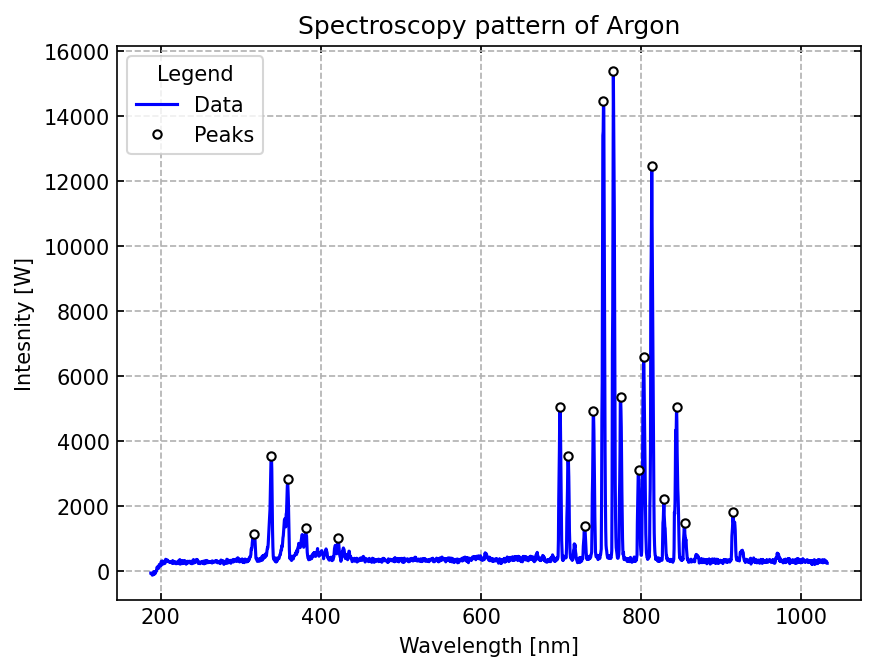

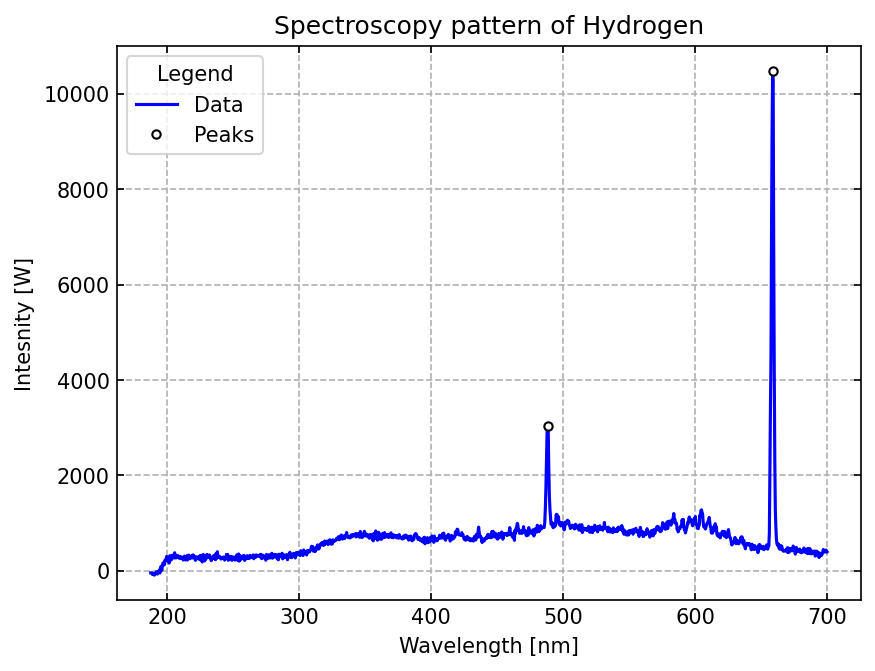

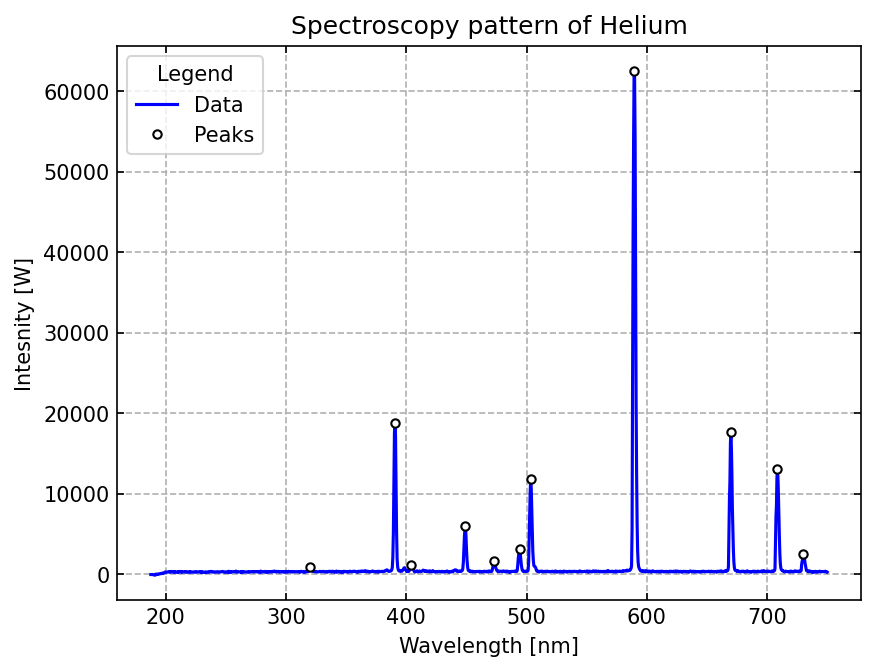

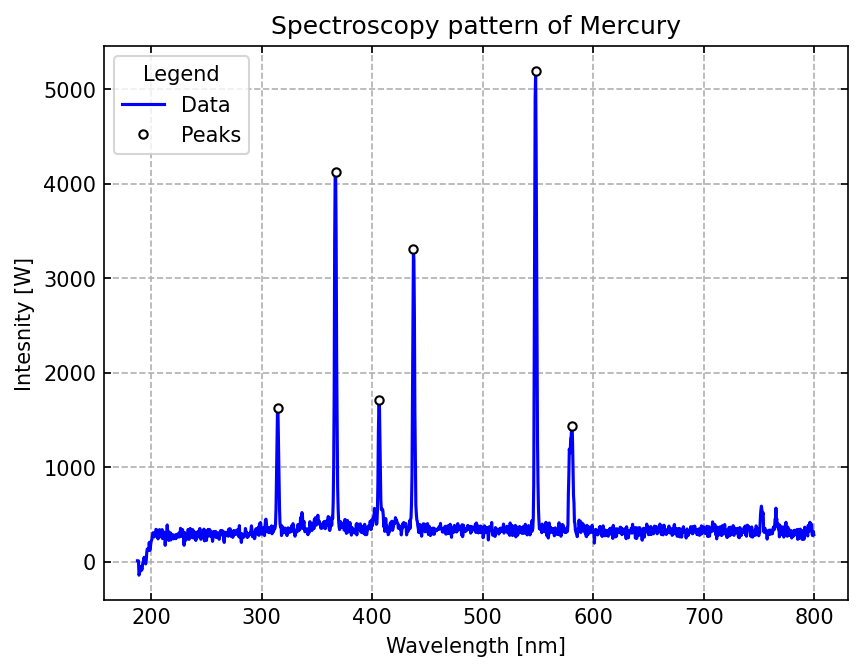

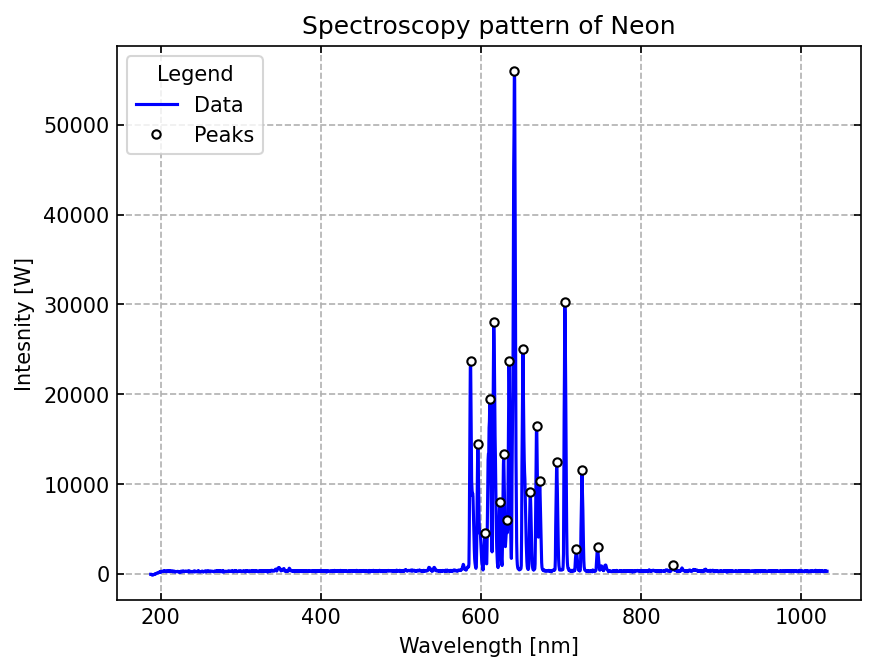

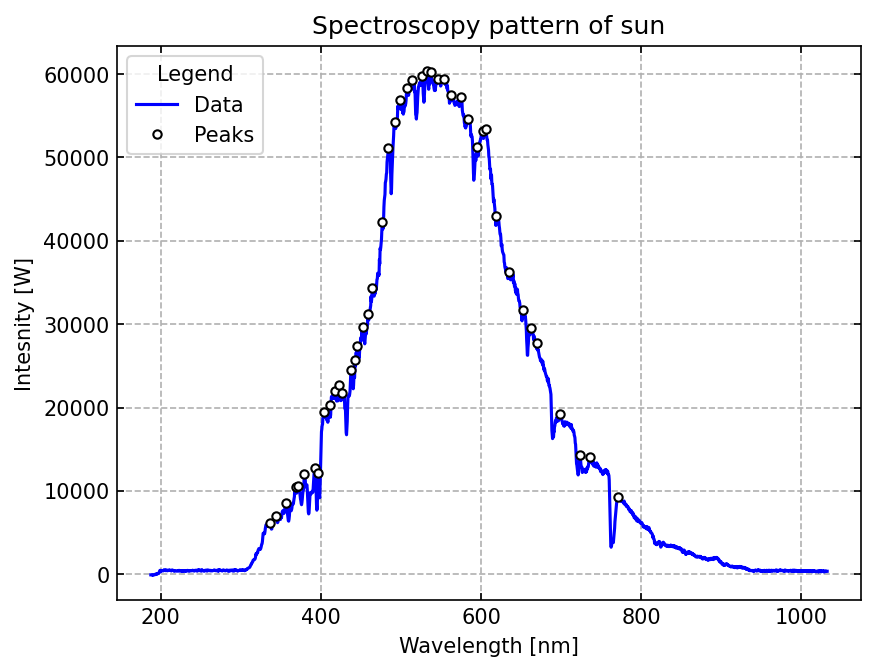

In [52]:
Wavelength_line = [] #store wavelength value for each found peak
names = ['Argon', 'Hydrogen', 'Helium', 'Mercury', 'Neon', 'sun']

for i, intensity in enumerate(Intensity):
    plt.figure()
    plt.plot(wavelength[i], intensity, color = 'blue', label = 'Data')
    peaks, _ = find_peaks(intensity, prominence = 700)
    peaks_wavelangth = [wavelength[i][peak] for peak in peaks]
    Wavelength_line.append(peaks_wavelangth)
    peaks_intensity = [intensity[peak] for peak in peaks]
    if i == 4: 
        print(peaks_wavelangth) 
        print(np.argmax(peaks_intensity))
    plt.plot(peaks_wavelangth, peaks_intensity, 'o', color = 'white', markeredgecolor = 'k', markersize = 4, label = 'Peaks')
    plt.title(f'Spectroscopy pattern of {names[i]}')
    plt.grid(ls = '--')
    plt.tick_params(direction = 'in', top = True, right = True)
    plt.xlabel('Wavelength [nm]')
    plt.ylabel('Intesnity [W]')
    plt.legend(loc = 'upper left', title = 'Legend')
    

In [53]:
Wavelength_line[1] #Found for hydrogen

[488.322, 658.743]

In [54]:
#Rydberg equation

R = 1.097e7
nf = 2
ni=[]

for i in range(len(Wavelength_line[1])):
    n = np.sqrt(-1*(nf**2-Wavelength_line[1][i]*R))
    ni.append(n)
    

ni #this gives the correct wavelengths, just at a factor of 100 out? fuck that, its correct.
#These wavelengths are proportional to a change from n=3->n=2 and n=4 -> n=2

[73190.7940659206, 85008.29786556134]

In [55]:
sun_data = np.loadtxt('Data_Labday_1/Labday_1_sun.txt', skiprows=1)
wavelength_err = np.full(len(sun_data), 0.2)  # Estimated from the measuredistance between wavelemngths

sun_wavelength = sun_data[:, 0]
sun_intensity = sun_data[:, 1]
var_intensity = np.sqrt(np.std(sun_intensity))

(300.0, 900.0)

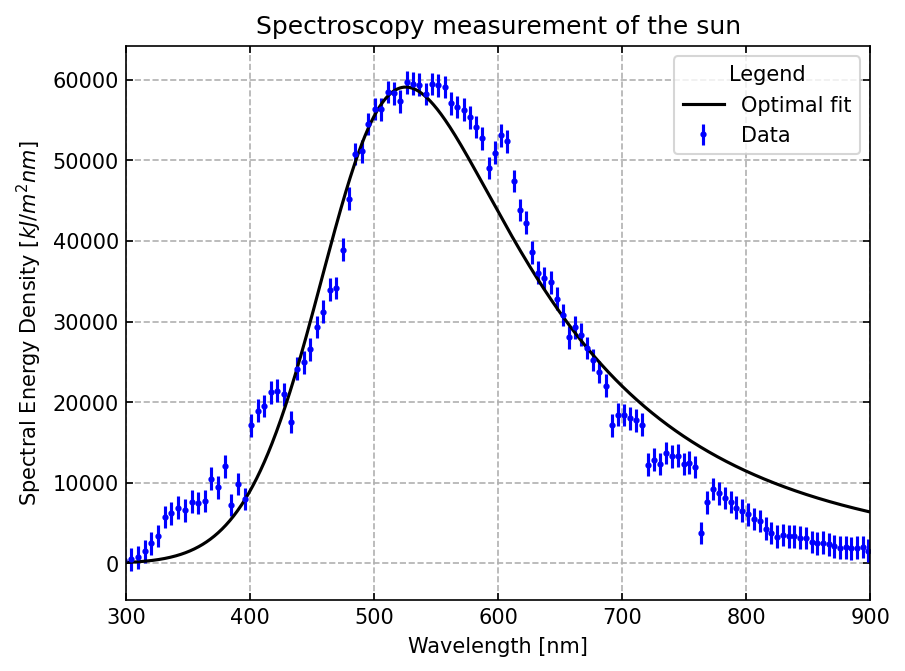

In [56]:
from scipy.optimize import curve_fit


def planck_fit(lam, *p):
    a = p[0]
    b = p[1]
    c = p[2]
    return (a / lam ** 5) * (1/(np.exp(b/lam ) - c))

a_guess = 2.36*10**20
b_guess = 2.4*10**3
c_guess = 1

p0 = [a_guess, b_guess, c_guess]

p_opt, p_cov = curve_fit(planck_fit, sun_wavelength, sun_intensity, p0 = p0, sigma = var_intensity, absolute_sigma = True)

plt.errorbar(sun_wavelength[1::12], sun_intensity[1::12], yerr= 10 * var_intensity, fmt = 'o', markersize = 2, color = 'blue', label = 'Data')
plt.plot(sun_wavelength, planck_fit(sun_wavelength, *p_opt), color = 'k', label = "Optimal fit")
#plt.plot(sun_wavelength, planck_fit(sun_wavelength, *p0), label = "Guess fit")
plt.title("Spectroscopy measurement of the sun")
plt.grid(ls = '--')
plt.tick_params(direction = 'in', top = True, right = True)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Spectral Energy Density [$kJ/m^2 nm$]')
plt.legend(loc = 'upper right', title = 'Legend')
plt.xlim((300, 900))

# FIllin this guy up!!!
# plt.fill_between(sun_wavelength, planck_fit(sun_wavelength, *(p_opt - 10 * np.sqrt(np.diag(p_cov)))), planck_fit(sun_wavelength, *(p_opt + 10* np.sqrt(np.diag(p_cov))))



In [57]:
max_sun = np.argmax(np.array(planck_fit(sun_wavelength, *p_opt)))
wavelength = sun_wavelength[max_sun]
wavelength

525.323

In [58]:
b_constant = 2.898 * 1e-3
actual_temp = 5772

Temp = b_constant/(wavelength * 1e-9)

print(f'THE SUN BE {Temp} KELVIN')


diff = (Temp-actual_temp)/((Temp+actual_temp)/2)*100
print(diff, "%")

THE SUN BE 5516.605973848472 KELVIN
-4.5248107116712495 %


<BarContainer object of 171 artists>

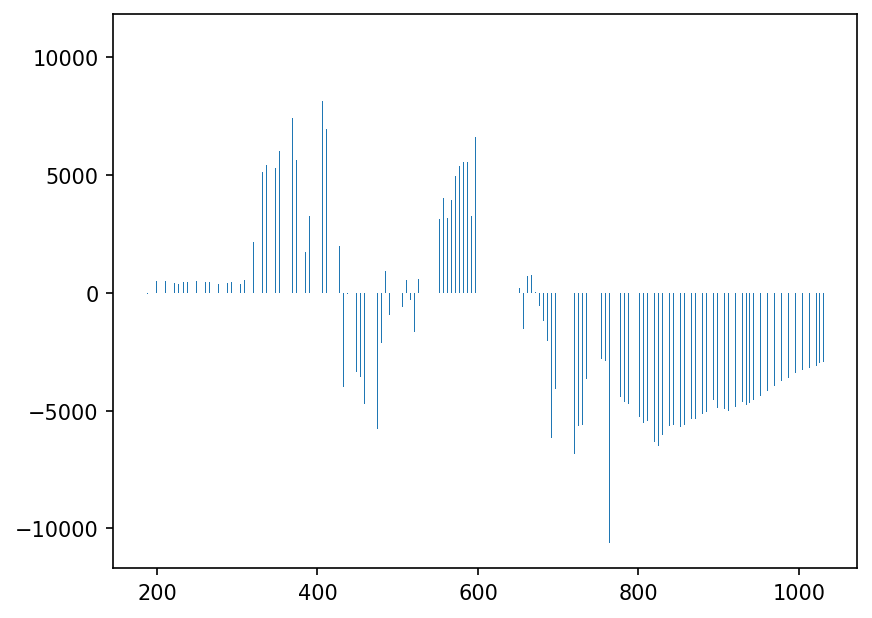

In [59]:
resdiuals = np.array([intens - planck_fit(sun_wavelength[1::12][i], *p_opt) for i, intens in enumerate(sun_intensity[1::12])])
plt.bar(sun_wavelength[1::12], resdiuals)

In [60]:
# Using law of accumaltion (if it is called like this)
dPda = lambda lam: 1/(lam**5 * (np.exp(p_opt[1]/lam) - p_opt[2]))
dPdb = lambda lam: p_opt[0] * np.exp(p_opt[1]/lam)/(lam**6 * (np.exp(p_opt[1]/lam) - p_opt[2])**2)
dPdc = lambda lam: p_opt[0] / (lam**5 * (np.exp(p_opt[1]/lam) - p_opt[2])**2)

alpha_P = np.sqrt(dPda(sun_wavelength)**2 * p_cov[0][0] + dPdb(sun_wavelength)**2 * p_cov[1][1] + dPdc(sun_wavelength)**2 * p_cov[2][2])

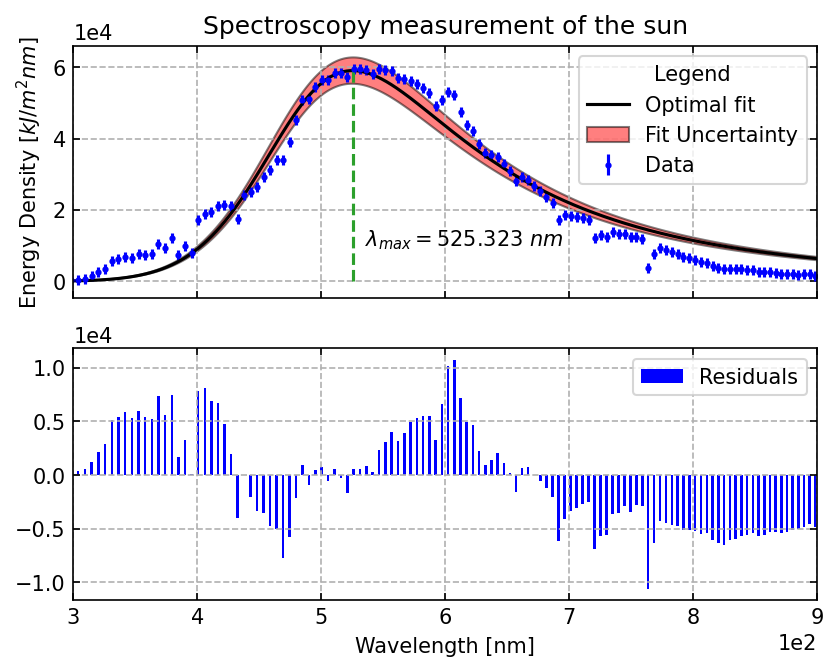

In [61]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True)

ax1.errorbar(sun_wavelength[1::12], sun_intensity[1::12], yerr= 10 * var_intensity, fmt = 'o', markersize = 2, color = 'blue', label = 'Data')
ax1.plot(sun_wavelength, planck_fit(sun_wavelength, *p_opt), color = 'k', label = "Optimal fit")
ax1.set_title("Spectroscopy measurement of the sun")
ax1.grid(ls = '--')
ax1.tick_params(direction = 'in', top = True, right = True)
ax1.set_ylabel('Energy Density [$kJ/m^2 nm$]', )
ax1.ticklabel_format(style='sci', scilimits= (3,2))
ax1.set_xlim((300, 900))
ax1.fill_between(sun_wavelength, planck_fit(sun_wavelength, *p_opt) - 10 * alpha_P, planck_fit(sun_wavelength, *p_opt) + 10 * alpha_P, color = 'red',
                 edgecolor = 'k', alpha = 0.5, label = 'Fit Uncertainty')
ax1.vlines(wavelength, 0, 6*1e4, linestyle = '--', color = 'tab:green')
ax1.text(wavelength + 10, 1e4, r'$\lambda_{max} = $' + f'{wavelength} $nm$')
ax1.legend(loc = 'upper right', title = 'Legend')

# Residuals
ax2.bar(sun_wavelength[1::12], resdiuals, color = 'blue', width = 2, label = 'Residuals')
ax2.grid(ls = '--')
ax2.tick_params(direction = 'in', top = True, right = True)
ax2.set_xlabel('Wavelength [nm]')
ax2.ticklabel_format(style='sci', scilimits=(3,2))
ax2.legend(loc = 'upper right')

plt.subplots_adjust(hspace=0.2)

### Pushin P

In [65]:
expected = planck_fit(sun_wavelength, *p_opt)
import scipy.stats as ss


chmin = np.sum(((sun_intensity - expected)/var_intensity)**2)
p_value = ss.t.sf(chmin, len(sun_intensity)-1)
chmin

1922596.4904630273

### Nevermind pushin P sucks, since the fit is so ass, that P BE FUCKIN 0

In [63]:
for i in range(len(p_opt)):
    print(f'{round(p_opt[i], 3)} \\pm {round(np.sqrt(np.diag(p_cov))[i], 3)}')

4.2444358303811306e+24 \pm 2.143505890105551e+22
7047.204 \pm 2.354
-1125701.233 \pm 5874.421
